In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib

import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import xarray as xr

from boutdata.restart import addvar
import glob
import shutil
import scipy
import netCDF4 as nc

sys.path.append(r"/home/mike/work/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.neutral_transport import NeutralTransport
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from hermes3.balance1d import *
# from code_comparison.code_comparison import *

%load_ext autoreload
%autoreload 2

In [2]:
db = CaseDB(
    case_dir = r"/home/mike/work/cases",
    grid_dir = r"/home/mike/work/cases"
    )

In [3]:
toload = [ 
    # dict(name="base", id="p2d1a-st40_lores_2e19_cvode", unnormalise_geom = True, use_xhermes = True, squash = False), 
    # dict(name="simplefields", id="p2d2a-simple_fields", unnormalise_geom = True, use_xhermes = True, squash = False),
    # dict(name="SNES", id="p2d3a-p2d2d_SNES", unnormalise_geom = True, use_xhermes = True, squash = False), 
    dict(name="power_x1.5", id="p2d3ab-power_x1.5", unnormalise_geom = True, use_xhermes = True, squash = False), 
]
cs = {}
for case in toload:
    cs[case["name"]] = db.load_case_2D(case["id"], use_squash = case["squash"], verbose = True)
    cs[case["name"]].extract_2d_tokamak_geometry()


- Reading case p2d3ab-power_x1.5
-----------------------


/home/mike/pyenvs/base-3.12.5/lib/python3.12/site-packages/xbout/load.py:1124: UserWarning: Will drop all variables containing the dimensions 't' because they are not recognised
  warn(



Unnormalising with xHermes


Text(0.5, 0, 'Simulation time (ms)')

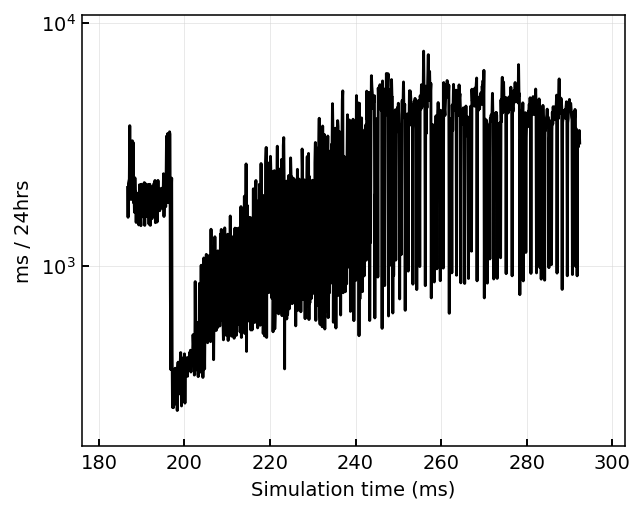

In [6]:
name = "power_x1.5"
stime = cs[name].ds["t"].values
wtime = cs[name].ds["wtime"].values
ms_per_24hrs = (stime) / (wtime/(60*60*24))  # ms simulated per 24 hours

fig, ax = plt.subplots()
ax.plot(stime[2:]*1e3, ms_per_24hrs[2:], label="SNES", c = "k")
ax.grid()
ax.set_yscale("log")
ax.set_ylabel("ms / 24hrs")
ax.set_xlabel("Simulation time (ms)")

In [4]:
ds = cs["simplefields"].ds


print((ds["Pd+_src"].hermesm.clean_guards() * ds["dv"]).sum().values * 1e-6 * 3/2)
print((ds["Pe_src"].hermesm.clean_guards() * ds["dv"]).sum().values * 1e-6 * 3/2)

10.149837999999999
7.713876879999999


/tmp/ipykernel_223079/611601851.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = [plt.cm.get_cmap("Spectral_r", tres)(x) for x in range(tres)]
/home/mike/work/sdtools/hermes3/plotting.py:756: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if "t" in  cases[name].dims.keys():


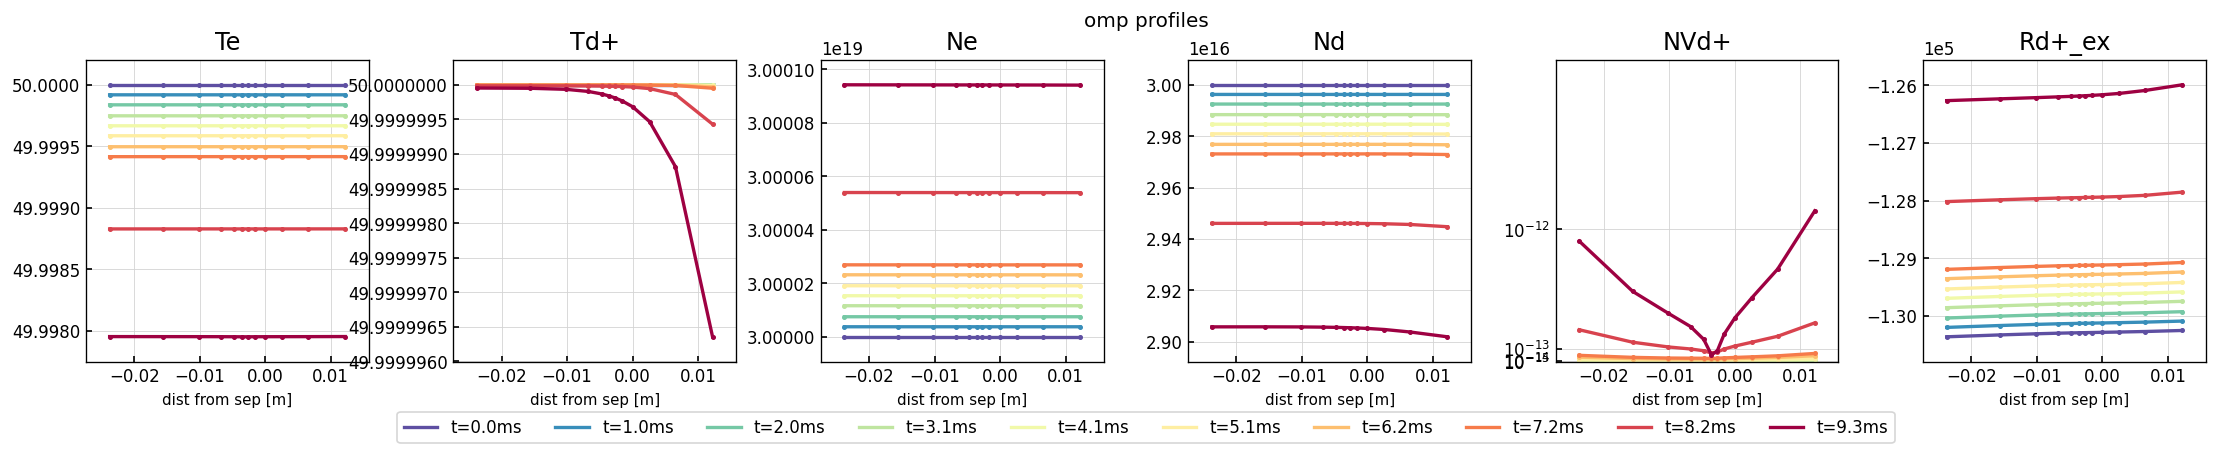

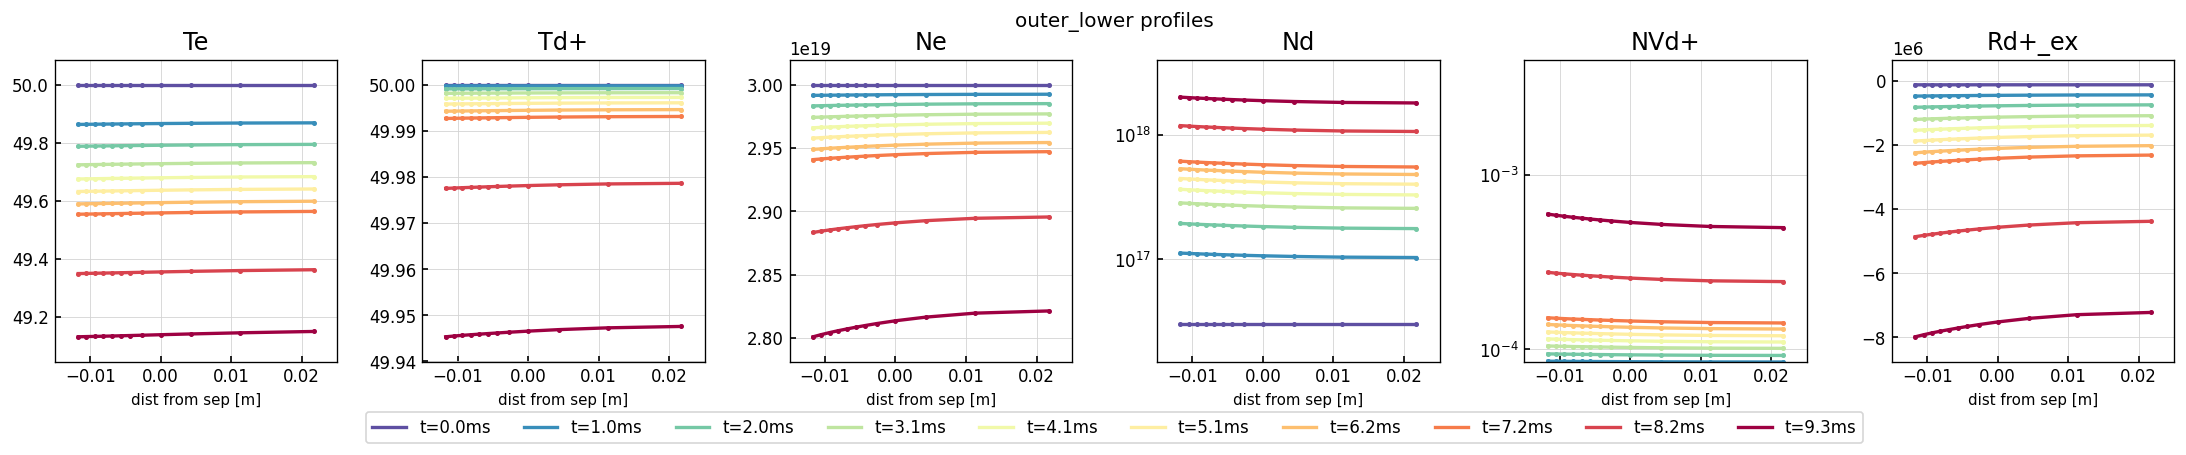

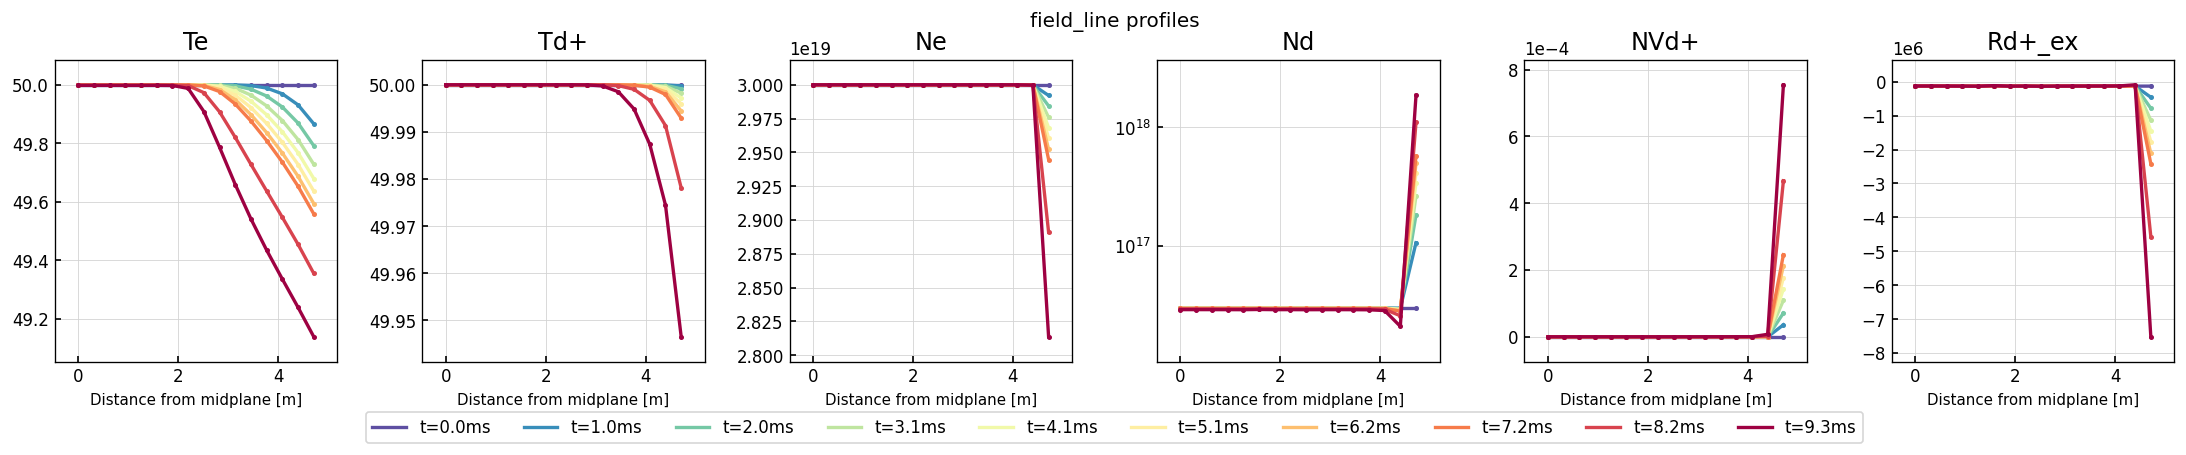

In [5]:
tlen = ds.sizes["t"]
if tlen > 10:
    tres = 10
else:
    tres = tlen
ts = np.linspace(0, tlen-1, tres, dtype = int)
colors = [plt.cm.get_cmap("Spectral_r", tres)(x) for x in range(tres)]

toplot = {}
for t in ts:
    toplot[f"t={t/10}ms"] = ds.isel(t=t, x = slice(2,-2))


lineplot(
    toplot,
    clean_guards = False,
    params = ["Te", "Td+",  "Ne", "Nd", "NVd+", "Rd+_ex"],
    regions = ["omp", "outer_lower", "field_line"],
    colors = colors,
    # save_name = save_name
)

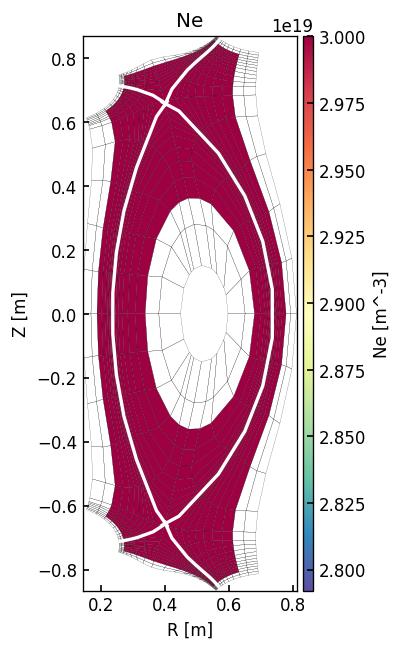

In [6]:
ds["Ne"].hermesm.clean_guards().bout.polygon(cmap = "Spectral_r", linewidth = 0.1, linecolor = "black", antialias = True)

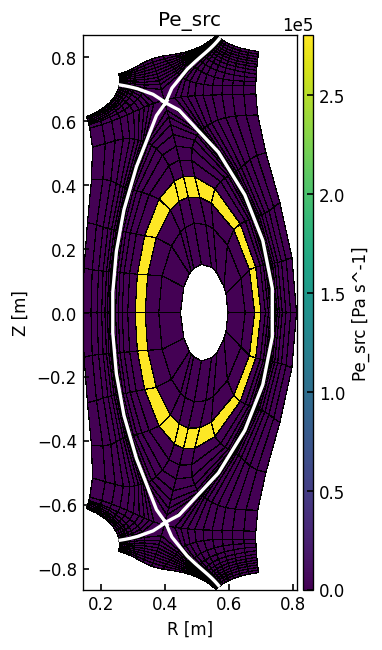

In [7]:
ds["Pe_src"].bout.polygon(linewidth = 0.1)

In [8]:
print(ds.hermesm.select_region("core_edge")["dv"].sum().values)

0.1950875910260526


In [9]:
ds = cs["base"].ds.isel(t=-1)

plot_selection(ds, ds.hermesm.select_region("core_edge"))

KeyError: 'base'

In [ ]:
ds = cs["base"].ds
[print(x) for x in ds.data_vars if "R" in x]

Rc
Rd+_ex
Rd+_rec


[None, None, None]

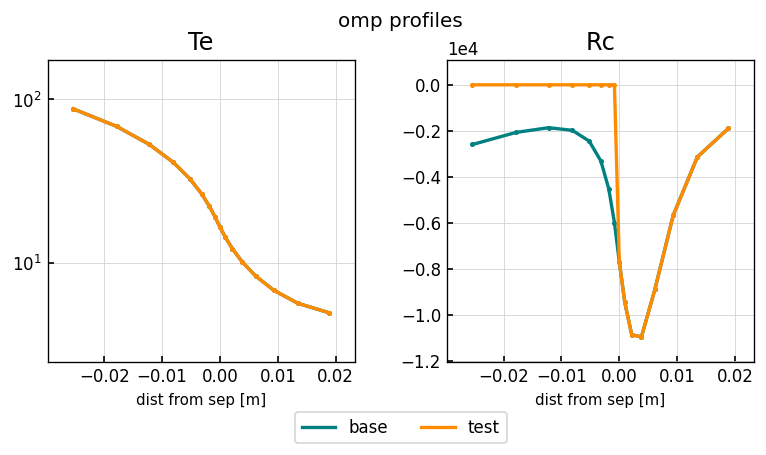

In [ ]:
toplot = {}
for name in cs:
    toplot[name] = cs[name].ds
    
lineplot(
        toplot,
        clean_guards = True,
        params = ["Te", "Rc"],
        # regions = ["omp", "outer_lower", "field_line"],
        regions = ["omp"],
        colors = ["teal", "darkorange"],
    )

Text(0.5, 1.0, 'Test: suppress core rad')

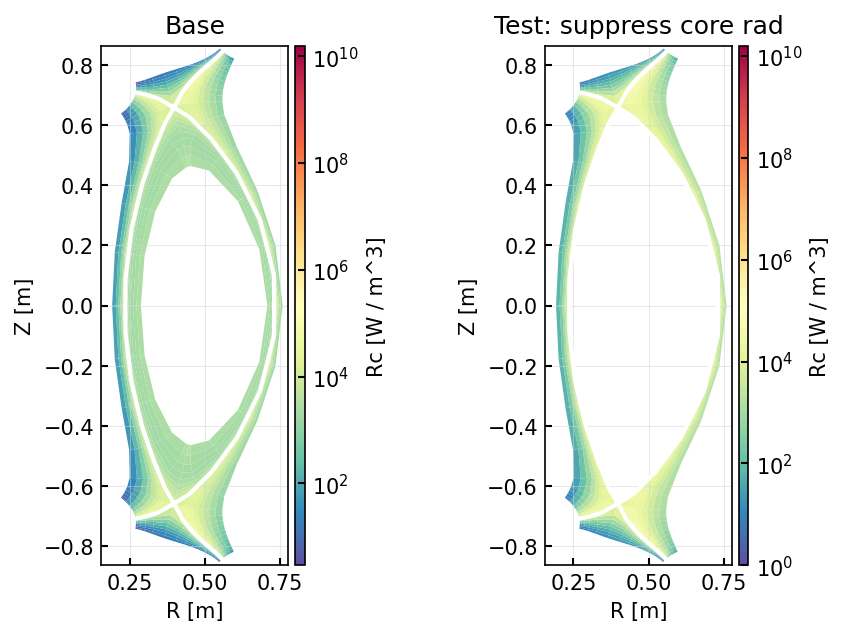

In [ ]:
cmap = "Spectral_r"

fig, axes = plt.subplots(1,2, figsize = (7,4.5), dpi = 150)

data = abs(cs["base"].ds["Rc"])
data.hermesm.clean_guards().bout.polygon(ax = axes[0], cmap = cmap, targets = False, 
                                                       separatrix_kwargs = dict(color="white", linestyle = "-", linewidth = 2),
                                                       antialias = True,
                                                       logscale = True,
                                                       vmin = np.nanmin(data.values), vmax = np.nanmax(data.values),
                                                      #  vmin = -1, vmax = 1,
                                                       
                                                       )
data = abs(cs["test"].ds["Rc"])
data.hermesm.clean_guards().bout.polygon(ax = axes[1], cmap = cmap, targets = False, 
                                                       separatrix_kwargs = dict(color="white", linestyle = "-", linewidth = 2),
                                                       antialias = True,
                                                       logscale = True,
                                                       vmin = np.nanmin(data.values)+1, vmax = np.nanmax(data.values),
                                                      #  vmin = -1, vmax = 1,
                                                       
                                                       )

axes[0].set_title("Base")
axes[1].set_title("Test: suppress core rad")
# ax.set_ylim(-0.9, 0)
